In [1]:
import sys
sys.path.append("/miniconda3/lib/python3.7/site-packages")

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import urllib as url
import os

In [3]:
flora11 = fits.open("calibrated-T21-nasuyu-Flora-20201128-220145-V-BIN1-W-180-001.fit")
flora12 = fits.open("calibrated-T21-nasuyu-Flora-20201128-220535-V-BIN1-W-180-002.fit")
flora13 = fits.open("calibrated-T21-nasuyu-Flora-20201128-220910-V-BIN1-W-180-003.fit")
flora21 = fits.open("calibrated-T21-nasuyu-Flora-20201204-220247-V-BIN1-W-180-001.fit")
flora22 = fits.open("calibrated-T21-nasuyu-Flora-20201204-220639-V-BIN1-W-180-002.fit")
flora31 = fits.open("calibrated-T21-nasuyu-Flora-20201209-220706-V-BIN1-W-180-001.fit")
flora32 = fits.open("calibrated-T21-nasuyu-Flora-20201209-221107-V-BIN1-W-180-002.fit")
m33 = fits.open("calibrated-T21-nasuyu-M33-20201128-214738-Luminance-BIN1-W-300-001.fit")

In [4]:
f11data = flora11[0].data #ra=02 19 17.00 dec=03 25 04.0 deg=34.821,3.084
f12data = flora12[0].data
f13data = flora13[0].data
f21data = flora21[0].data #ra=02 17 11.00 dec=03 53 35.0 deg=34.296,3.051
f22data = flora22[0].data
f31data = flora31[0].data #ra=02 16 26.00 dec=04 23 16.0 deg=34.108,4.052
f32data = flora32[0].data
m33data = m33[0].data

In [317]:
FOV=49.2
f=1940
p=.009

In [157]:
np.shape(f11data)

(2048, 3072)

In [ ]:
def get_star_list(img, threshold):
    """Return a list of the approximate positions of stars in img that exceed threshold brightness.
    """
    STAR_SIZE=10
    star_list = []

    # Look through entire image except within STAR_SIZE of the edges
    for i in range(STAR_SIZE, len(img) - STAR_SIZE):
        for j in range(STAR_SIZE, len(img[0]) - STAR_SIZE):
        
            if img[i][j] > threshold:
            
                # Potential star candidate!
                new_star = True
                
                # First test: check one pixel above, below, left, and right to confirm 
                # that this is reasonably a star and not a single bright pixel
                for n in range(-1, 2):
                    for m in range(-1, 2):
                        if not img[i + n][j + m] > threshold:
                            new_star = False
                
                # Only proceed if still a star candidate
                if new_star:
                    
                    # Determine if this star is already listed
                    for n in range(-STAR_SIZE, STAR_SIZE + 1):
                        for m in range(-STAR_SIZE, STAR_SIZE + 1):
                            if [i + n, j + m] in star_list:
                                new_star = False
                
                    # Only add this position if the star is not already listed
                    if new_star:
                        star_list.append([i, j])
    
    return star_list

In [318]:
f11u=search_usno(f11rd_deg[0],f11rd_deg[1],FOV)

In [321]:
f11u14=[]
for i in range(0,len(f11u[0])):
    if f11u[3][i]<14:
        f11u14.append([f11u[0][i],f11u[1][i]])

In [324]:
f11u14n = np.asarray(f11u14)

In [165]:
def get_XY(alpha, delta, alpha0, delta0):

    #Convert all degree quantities to radians
    alpha = np.deg2rad(alpha)
    delta = np.deg2rad(delta)
    alpha0 = np.deg2rad(alpha0)
    delta0 = np.deg2rad(delta0)
    
    #Compute the projection relative to the center of the field
    X = np.cos(delta)*np.sin(alpha - alpha0)
    Y = np.sin(delta0)*np.cos(delta)*np.cos(alpha - alpha0) - np.cos(delta0)*np.sin(delta)
    norm = np.cos(delta0)*np.cos(delta)*np.cos(alpha - alpha0)+np.sin(delta0)*np.sin(delta)
    
    return X/norm, -1*Y/norm

In [237]:
#def approximate_transform(reference_stars, center_of_field, rotation_angle):

    image_shape=[2048, 3072]
    focal_length = 1940
    pixel_size = .009
    
    #Intialize an array to hold to transformed co-ordinates
    transform_reference_stars = np.empty_like(reference_stars)

    #Convert data products to the required format for computation
    alpha0, delta0 = convert2deg(*center_of_field)
    rotation_angle = np.deg2rad(rotation_angle)
    
    #For each star
    for i in range(np.shape(reference_stars)[0]):

        #Extract parameters
        #star = reference_stars[i,:]
        alpha, delta = reference_stars[i][0], reference_stars[i][1]

        #Project onto a plane
        X, Y = get_XY(alpha, delta, alpha0, delta0)

        #Convert to approximate CCD pixel co-ordinates
        x = focal_length*(X/pixel_size) 
        y = focal_length*(Y/pixel_size) 

        #Apply a standard rotation
        x_rot = x*np.cos(rotation_angle) - y*np.sin(rotation_angle)
        y_rot = x*np.sin(rotation_angle) + y*np.cos(rotation_angle)

        #Center values on the CCD and add to the array of transformed co-ordinates
        transform_reference_stars[i,0] = x_rot + image_shape[1]/2.0 
        transform_reference_stars[i,1] = y_rot + image_shape[0]/2.0
        
    return transform_reference_stars


In [322]:
def approximate_transform(reference_stars, center_of_field, rotation_angle):

    image_shape=[2048, 3072]
    focal_length = 1940
    pixel_size = .009
    
    #Intialize an array to hold to transformed co-ordinates
    transform_reference_stars = np.empty_like(reference_stars)

    #Convert data products to the required format for computation
    alpha0, delta0 = convert2deg(*center_of_field)
    rotation_angle = np.deg2rad(rotation_angle)
    
    #For each star
    for i in range(reference_stars.shape[0]):

        #Extract parameters
        star = reference_stars[i,:]
        alpha, delta = star[0], star[1]

        #Project onto a plane
        X, Y = get_XY(alpha, delta, alpha0, delta0)

        #Convert to approximate CCD pixel co-ordinates
        x = focal_length*(X/pixel_size) 
        y = focal_length*(Y/pixel_size) 

        #Apply a standard rotation
        x_rot = x*np.cos(rotation_angle) - y*np.sin(rotation_angle)
        y_rot = x*np.sin(rotation_angle) + y*np.cos(rotation_angle)

        #Center values on the CCD and add to the array of transformed co-ordinates
        transform_reference_stars[i,0] = x_rot + image_shape[1]/2.0 
        transform_reference_stars[i,1] = y_rot + image_shape[0]/2.0
        
    return transform_reference_stars


In [325]:
atf11u14=(approximate_transform(f11u14n,(flora11[0].header['RA'],flora11[0].header['DEC']),359))

TypeError: ufunc 'deg2rad' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [278]:
x=[]
y=[]
X=[]
Y=[]
for i in f11list:
    X.append(i[0])
    Y.append(i[1])
for i in f11cen:
    x.append(i[0])
    y.append(i[1])

In [279]:
def 

In [310]:
x11=[]
y11=[]
for i in atf21:
    x11.append(i[0])
    y11.append(i[1])

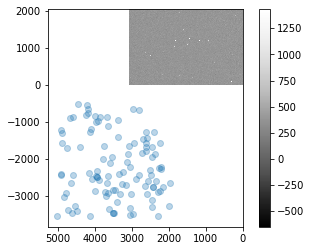

In [311]:
plot(f21data)
plt.plot(x11,y11,'o',alpha=.3) #usno transform
#plt.plot(y,x,'o',alpha=.3,c='yellow') #finder function
plt.show()

In [303]:
f11usno.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [181]:
n=np.array([],[])

In [ ]:
# Helper function

def is_new_star(star_yx: List[int], star_list: List[List[int]]) -> bool:
    """Return True if and only if yx-coordinates in the neighbourhood of star_yx are not listed in star_list.
    The neighbourhood of star is a pair of coordinates within STAR_SIZE of star_yx.
    """
    
    for n in range(-STAR_SIZE, STAR_SIZE + 1):
        for m in range(-STAR_SIZE, STAR_SIZE + 1):
            
            if [star_yx[0] + n, star_yx[1] + m] in star_list:
                return False
    
    return True

In [ ]:
def get_star_list(img: np.array, threshold: int) -> List[List[int]]:
    """Return a list of the approximate yx-positions of stars in img that exceed threshold brightness.
    """

    star_list = []

    # Look through entire image except within STAR_SIZE of the edges
    for i in range(STAR_SIZE, len(img) - STAR_SIZE):
        for j in range(STAR_SIZE, len(img[0]) - STAR_SIZE):
        
            if img[i][j] > threshold:
            
                # Potential star candidate!
                star = True
                
                # First test: Check one pixel above, below, left, and right to confirm 
                # that this is reasonably a star and not a single bright pixel
                for n in range(-1, 2):
                    for m in range(-1, 2):
                        
                        if not img[i + n][j + m] > threshold:
                            star = False
                
                # Only proceed if still a star candidate
                if star:
                    
                    # Second test: Check if this star is already listed
                    # and only add its position if it isn't
                    if is_new_star([i, j], star_list):
                        star_list.append([i, j])
                        
    return star_list

In [ ]:
def centroid_stars(star_list: List[List[int]], img: np.array) -> Tuple[np.array]:
    """Return three parallel one-dimensional arrays. The first is an array of the x-coordinates of the centroids 
    of the stars in img listed in star_list. The second is the y-coordinates of the centroids of these stars. 
    The third is the total brightness of these stars.
    """

    brightness_list = []
    x_brightness_list = []
    y_brightness_list = []

    for star_yx in star_list: 
    
        brightness = 0
        x_brightness = 0
        y_brightness = 0
    
        # For each approximate star position, evaluate pixels in a square around this position
        for i in range(star_yx[0] - STAR_SIZE, star_yx[0] + STAR_SIZE + 1):
            for j in range(star_yx[1] - STAR_SIZE, star_yx[1] + STAR_SIZE + 1):
                            
                brightness += img[i][j]
                x_brightness += j * img[i][j]
                y_brightness += i * img[i][j]
    
        brightness_list.append(brightness)
        x_brightness_list.append(x_brightness)
        y_brightness_list.append(y_brightness)

    brightness_array = np.array(brightness_list)
    x_brightness_array = np.array(x_brightness_list)
    y_brightness_array = np.array(y_brightness_list)

    x_centroid_array = x_brightness_array / brightness_array
    y_centroid_array = y_brightness_array / brightness_array

    return (x_centroid_array, y_centroid_array, brightness_array)